In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
%matplotlib notebook
import matplotlib.pylab as plt

import numpy as np
import pandas as pd
import h5py
from os import listdir
from os.path import join

import sys
sys.path.append("../src")
from convert_matlab73_hdf5 import recursive_dict
%aimport eeg_dataset_utils

In [3]:
path = '../../Mar25/' # Cambiar esto
files = sorted(listdir(path))
display(files)

with h5py.File(join(path, files[0]), 'r') as f:
    matlab_dict = recursive_dict(f)

['FT_DataSet_Pablo Burgos_Sess1CompRej.mat',
 'FT_DataSet_Pablo Burgos_Sess2CompRej.mat',
 'FT_DataSet_Pablo Burgos_Sess3CompRej.mat',
 'FT_DataSet_Pablo Burgos_Sess4CompRej.mat',
 'FT_DataSet_Pablo Burgos_Sess5CompRej.mat',
 'FT_DataSet_Pablo Burgos_Sess6CompRej.mat',
 'FT_DataSet_Pablo Burgos_Sess7CompRej.mat',
 'FT_DataSet_Pablo Burgos_Sess8CompRej.mat',
 'FT_DataSet_Pablo Burgos_Sess9CompRej.mat']

In [4]:
display(type(matlab_dict["data"]), matlab_dict["data"].keys())

dict

dict_keys(['cfg', 'fsample', 'label', 'sampleinfo', 'time', 'trial', 'trialinfo'])

Explicación de cada llave (sólo las importantes para este caso):

- trial: Vector con la EEG asociado a cada trial
- time: Tiempos para cada trial
- label:  Los Canales de la EEG (VEOG y HEOG son canales oculares y podrían removerse)
- fsample: Frecuencia de muestreo
- trialinfo: Especificado a continuación



In [5]:
display(type(matlab_dict['data']['trialinfo']), 
        matlab_dict['data']['trialinfo'].shape)

numpy.ndarray

(10, 1315)

Explicación de las filas relevantes:

- 4: Número de sesión
- 5: Número de trial dentro de cada sesión
- 6: stimulus position (E1(1), M(2) or E2(3)) 

Cada trial esta compuesto por la presentacion secuencia de 3 estímulos de la misma categoría, el sujeto debe responder si el tercer y el primer estimulo son iguales o diferentes

- 7: Identidad de cada estimulo, eran 30 en total
- 8: Si el estimulo estaba rotado a la derecha (1) o a la izquierda(counter 0)
- 9: Tiempo que demoró el sujeto en responder despues de la presentacion de cada estimulo
- 10: Botón que apreto el sujeto, en este caso el sujeto debia apretar el boton derecho (7) para decir que eran iguales, o izquierdo (6) para decir si eran diferentes, o nulo (0) si no apretó. 

La lógica para determinar que un trial sea correcto, 
- Es establecer si el trial (trialinfo(:,5)), tenia el estimulo E1(1) y estimulo E2(3) (trialinfo(:,6)). 
- Si es que los tiene (puede ser que se haya eliminado en el proceso de "limpiado" de la señal), se establece que la identidad sea la misma o no (trialinfo(:,7)). 
- Si la identidad de los dos estimulos es la misma, entonces se evalúa si el sujeto respondio igual o diferente (trialinfo(:,10))

***

In [6]:
eeg_names = matlab_dict['data']['cfg']['previous']['channel']
trial = matlab_dict['data']['trial']
trial_info = matlab_dict['data']['trialinfo']
times = matlab_dict['data']['time']

session_number = trial_info[3, 0].astype(int)
trial_number = trial_info[4, :].astype(int)
stimulus_pos = trial_info[5, :].astype(int)
stimulus_id = trial_info[6, :].astype(int)
stimulus_rot = trial_info[7, :].astype(int)
trial_answer = trial_info[9, :].astype(int)

Función para determinar los trials válidos y si sus respuestas son correctas

In [7]:
from IPython.core import page
page.page = print
%psource eeg_dataset_utils.get_valid_ids_and_labels

def get_valid_ids_and_labels(trial_number, stimulus_id, stimulus_pos, trial_answer, debug=False):
    valid_trial_ids = []
    labels = []
    for experiment_number in np.unique(trial_number):
        mask = trial_number == experiment_number
        trial_pos = stimulus_pos[mask]
        trial_id = stimulus_id[mask]
        answer = trial_answer[mask][0]     
        # A valid trial has to has stimulus 1 and 3
        if 1 in trial_pos and 3 in trial_pos:            
            equal_stimulus = trial_id[trial_pos==1] == trial_id[trial_pos==3]            
            # Check if answer was correct, ommisions are considered incorrect
            label = ((answer==6) & ~equal_stimulus) | ((answer==7) & equal_stimulus)
            if debug:
                print(answer, trial_pos, trial_id, equal_stimulus, answer, label)
            valid_trial_ids.append(experiment_number)
            labels.append(label)
    return valid_trial_ids, np.array(labels)[:, 0].astype(int)



In [8]:
valid_trial_ids, labels = eeg_dataset_utils.get_valid_ids_and_labels(trial_number, stimulus_id, 
                                                                     stimulus_pos, trial_answer)
mask_first_stimulus = (stimulus_pos == 1) & np.array([trial in set(valid_trial_ids) for trial in trial_number]) 
mask_third_stimulus = (stimulus_pos == 3) & np.array([trial in set(valid_trial_ids) for trial in trial_number])   

Visualizar todos los trials para un canal en particular anotando con color según su respuestas

<IPython.core.display.Javascript object>


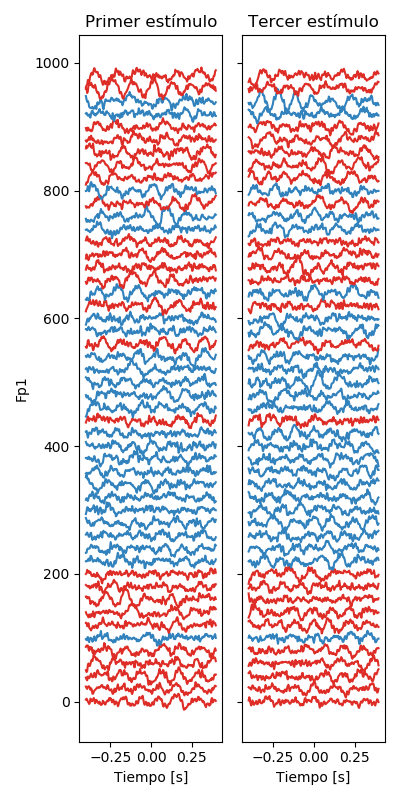

Text(0.5, 1.0, 'Tercer estímulo')

In [9]:
fig, ax = plt.subplots(ncols=2, figsize=(4, 8), tight_layout=True, 
                       sharex=True, sharey=True)

channel = 2
ax[0].set_ylabel(eeg_names[channel])
color = {True: '#3182bd', False: '#de2d26'}
for i in range(50):
    ax[0].plot(times[i, 400:600], 20*i+trial[mask_first_stimulus, 400:600, channel][i], color=color[labels[i]])
    ax[1].plot(times[i, 400:600], 20*i+trial[mask_third_stimulus, 400:600, channel][i], color=color[labels[i]])
ax[0].set_xlabel('Tiempo [s]')
ax[1].set_xlabel('Tiempo [s]')
ax[0].set_title('Primer estímulo')
ax[1].set_title('Tercer estímulo')

Visualizar todos los canales para un trial en particular

<IPython.core.display.Javascript object>


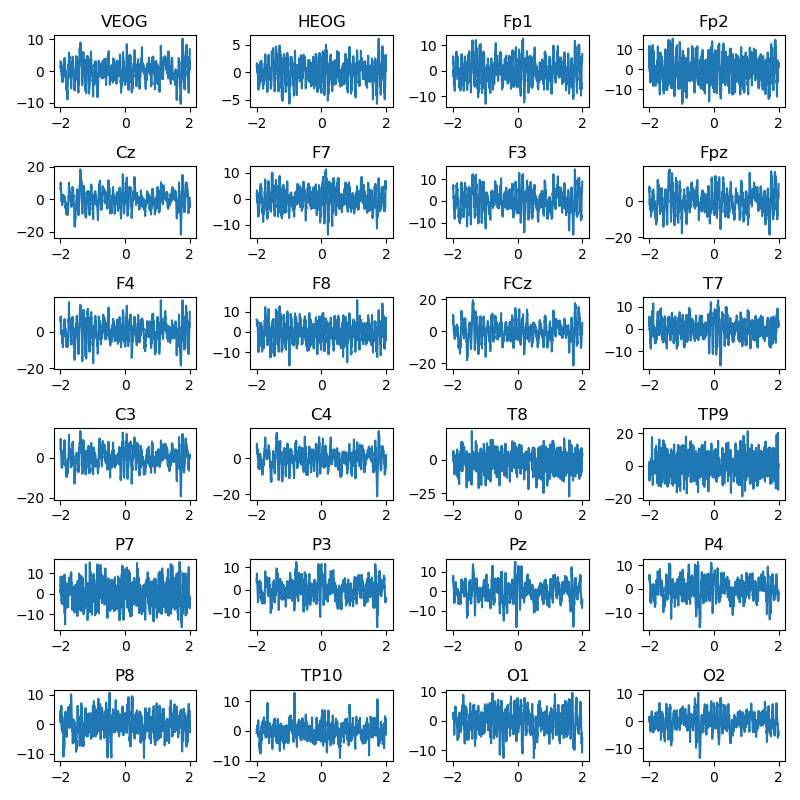

In [10]:
fig, ax = plt.subplots(6, 4, figsize=(8, 8),tight_layout=True)
for i in range(6):
    for j in range(4):
        ax[i, j].plot(times[0, :], trial[0, :, 4*i+j])
        ax[i, j].set_title(eeg_names[4*i+j])